<a href="https://colab.research.google.com/github/antonellagambarte/proyecto-final-CEIA/blob/main/LIMPIEZA_DATASET_NHANES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.model_selection import train_test_split


In [161]:
# Leer el archivo
ruta_archivo = '/content/drive/My Drive/NHANES/df_min.csv'
df = pd.read_csv(ruta_archivo)

# Verificar que los datos llegaron bien
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id_paciente                             5568 non-null   float64
 1   tipo_entrevista                         5568 non-null   float64
 2   edad                                    5568 non-null   float64
 3   genero                                  5568 non-null   float64
 4   presion_sis_1                           4658 non-null   float64
 5   presion_sis_2                           4885 non-null   float64
 6   presion_sis_3                           4872 non-null   float64
 7   colesterol_total                        4936 non-null   float64
 8   hdl                                     4936 non-null   float64
 9   ldl                                     2368 non-null   float64
 10  trigliceridos                           2393 non-null   floa

In [162]:
# Diccionario optimizado con todas las variables que presentan códigos de error
criterios_error = {
    # Variables con códigos 7 y 9
    'fam_cardio': [7, 9], 'fam_asma': [7, 9], 'fam_diabetes': [7, 9],
    'diabetes': [7, 9], 'hipertension': [7, 9], 'act_caminar_bici': [7, 9],
    'act_moderada': [7, 9], 'anhedonia': [7, 9], 'deprimido_decaido': [7, 9],
    'prediabetes_glucosa_alterada': [7, 9], 'ACV': [7, 9], 'colesterol_alto': [7, 9],
    'medicacion_colesterol': [7, 9], 'riñones_debiles_fallando': [7, 9],

    # Variables con códigos 77 y 99
    'actividad_deportiva_moderada_x_semana': [77, 99],
    'consumo_alcohol_ultimo_año': [77, 99],
    'consumo_excesivo_alcohol_ultimo_año': [77, 99],
    'horas_suenio': [77, 99],

    # Variables con códigos 777 y 999
    'alcohol_promedio': [777, 999],
    'veces_consumo_excesivo_alcohol_30_dias': [777, 999]
}

print(f"{'Variable':<40} | {'Casos de Error':<15} | {'% del Total':<10}")
print("-" * 75)

total_filas = len(df)

for col, codigos in criterios_error.items():
    if col in df.columns:
        cantidad = df[col].isin(codigos).sum()
        porcentaje = (cantidad / total_filas) * 100
        print(f"{col:<40} | {cantidad:<15} | {porcentaje:>8.2f}%")

Variable                                 | Casos de Error  | % del Total
---------------------------------------------------------------------------
fam_cardio                               | 127             |     2.28%
fam_asma                                 | 111             |     1.99%
fam_diabetes                             | 81              |     1.45%
diabetes                                 | 4               |     0.07%
hipertension                             | 10              |     0.18%
act_caminar_bici                         | 6               |     0.11%
act_moderada                             | 5               |     0.09%
anhedonia                                | 7               |     0.13%
deprimido_decaido                        | 6               |     0.11%
prediabetes_glucosa_alterada             | 6               |     0.11%
ACV                                      | 9               |     0.16%
colesterol_alto                          | 39              |     0.70%

Los valores como 9, 99 o 999, 77, 777 son códigos técnicos que indican que el paciente no conocía la respuesta o prefirió no contestar. Es fundamental transformarlos en valores nulos porque, de lo contrario, el modelo los interpretaría como cifras médicas reales, lo que provocaría diagnósticos erróneos al considerar un código administrativo como un valor de salud extremo.

Dado que los porcentajes no son altos, se les asigna NaN para luego imputarlos

In [163]:
for col, codigos in criterios_error.items():
    if col in df.columns:
        # Reemplazamos los códigos de error por NaN
        df[col] = df[col].replace(codigos, np.nan)

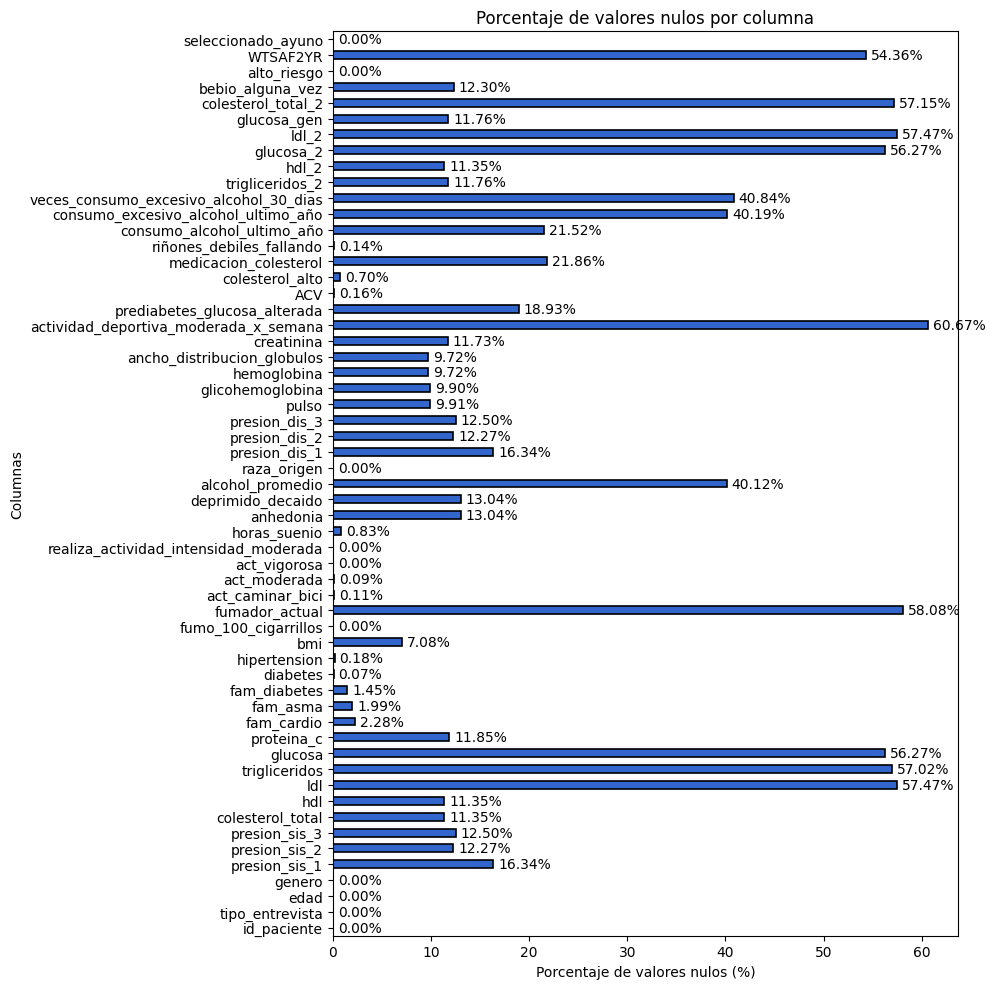

In [164]:
porcentaje_nulos = df.isna().mean().round(4) * 100

plt.figure(figsize=(10, 10))
porcentaje_nulos.plot(kind='barh', color="#3366CC", edgecolor='black', linewidth=1.2)

plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Porcentaje de valores nulos (%)')
plt.ylabel('Columnas')

for index, value in enumerate(porcentaje_nulos):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center')

plt.tight_layout()
plt.show()

### **SPLIT DATASET**

In [165]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['alto_riesgo'],
    random_state=42
)

# Create explicit copies of `df_train` and `df_test`.
df_train = df_train.copy()
df_test = df_test.copy()

print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_test: {df_test.shape}")
print(f"Distribution of 'alto_riesgo' in df_train:\n{df_train['alto_riesgo'].value_counts(normalize=True)}")
print(f"Distribution of 'alto_riesgo' in df_test:\n{df_test['alto_riesgo'].value_counts(normalize=True)}")

Shape of df_train: (4454, 57)
Shape of df_test: (1114, 57)
Distribution of 'alto_riesgo' in df_train:
alto_riesgo
0    0.905254
1    0.094746
Name: proportion, dtype: float64
Distribution of 'alto_riesgo' in df_test:
alto_riesgo
0    0.905745
1    0.094255
Name: proportion, dtype: float64


### **BMI**

In [166]:
print("--- PERFIL DE NULOS EN BMI ---")

# 1. ¿Cuántos nulos hay realmente?
total_nulos_bmi = df['bmi'].isnull().sum()
print(f"Total nulos: {total_nulos_bmi} ({ (total_nulos_bmi/len(df))*100 :.2f}%)")

# 2. ¿Hay sesgo de género?
print("\nDistribución por Género en nulos de BMI:")
print(df[df['bmi'].isnull()]['genero'].value_counts(normalize=True))

# 3. ¿Hay sesgo por Edad?
print("\nEdad promedio de los nulos:")
print(df[df['bmi'].isnull()]['edad'].mean())
print("Edad promedio de los NO nulos:")
print(df[df['bmi'].notnull()]['edad'].mean())

# 4. ¿Están relacionados con los nulos de presión?
# Usamos 'presion_sis_1' que ya viene en el CSV original
ambos_nulos = df[df['bmi'].isnull() & df['presion_sis_1'].isnull()].shape[0]
print(f"\nPacientes que no tienen NI presión (Medida 1) NI BMI: {ambos_nulos}")

--- PERFIL DE NULOS EN BMI ---
Total nulos: 394 (7.08%)

Distribución por Género en nulos de BMI:
genero
1.0    0.530457
2.0    0.469543
Name: proportion, dtype: float64

Edad promedio de los nulos:
54.9263959390863
Edad promedio de los NO nulos:
51.24101275608813

Pacientes que no tienen NI presión (Medida 1) NI BMI: 335


Imputación con mediana por rango de edad

In [167]:
# # 1. Crear el rango de edad (décadas) para que la imputación sea biológicamente coherente
# df['rango_edad'] = (df['edad'] // 10) * 10

# # 2. Realizar la imputación por estratos
# # Esto asigna la mediana de BMI de personas del mismo sexo y rango de edad
# df['bmi'] = df.groupby(['genero', 'rango_edad'])['bmi'].transform(lambda x: x.fillna(x.median()))

# # 3. Red de seguridad
# # Por si existe algún grupo demográfico sin ningún dato (muy poco probable en NHANES)
# if df['bmi'].isnull().any():
#     df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# print("--- VERIFICACIÓN DE BMI ---")
# print(f"Nulos restantes en BMI: {df['bmi'].isnull().sum()}")
# print(f"Estadísticas del BMI post-imputación:\n{df['bmi'].describe()}")

In [168]:
# Se crear el rango de edad (décadas) para que la imputación
df_train['rango_edad'] = (df_train['edad'] // 10) * 10
df_test['rango_edad'] = (df_test['edad'] // 10) * 10

# Cálculo de mediana para df_train
bmi_medians = df_train.groupby(['genero', 'rango_edad'])['bmi'].median()

# Imputación en df_train
df_train['bmi'] = df_train.groupby(['genero', 'rango_edad'])['bmi'].transform(
    lambda x: x.fillna(x.median())
)

# Imputación en test usando medianas calculadas para train
for index, row in df_test[df_test['bmi'].isnull()].iterrows():
    gender = row['genero']
    age_range = row['rango_edad']
    if (gender, age_range) in bmi_medians.index:
        df_test.loc[index, 'bmi'] = bmi_medians.loc[(gender, age_range)]


overall_median_bmi_train = df_train['bmi'].median()
df_train['bmi'] = df_train['bmi'].fillna(overall_median_bmi_train)
df_test['bmi'] = df_test['bmi'].fillna(overall_median_bmi_train)

# Se borra rango_edad
df_train.drop(columns=['rango_edad'], inplace=True)
df_test.drop(columns=['rango_edad'], inplace=True)

print("BMI imputation complete.")
print(f"Missing BMI in df_train: {df_train['bmi'].isnull().sum()}")
print(f"Missing BMI in df_test: {df_test['bmi'].isnull().sum()}")

BMI imputation complete.
Missing BMI in df_train: 0
Missing BMI in df_test: 0


### **PRESION**

En este caso, se tienen 3 medidas. Primero, para cada fila, vamos a hacer el promedio de los valores que se tengan para que obtengamos una sola columna con los valores de presion sistolica y otra distolica.

In [169]:
# Lista de columnas de presión
columnas_presion = [
    'presion_sis_1', 'presion_sis_2', 'presion_sis_3',
    'presion_dis_1', 'presion_dis_2', 'presion_dis_3'
]

# Contamos cuántos ceros hay en cada una
for col in columnas_presion:
    ceros = (df[col] == 0).sum()
    nulos = df[col].isna().sum()
    print(f"{col}: {ceros} valores en cero | {nulos} valores nulos (NaN)")

presion_sis_1: 0 valores en cero | 910 valores nulos (NaN)
presion_sis_2: 0 valores en cero | 683 valores nulos (NaN)
presion_sis_3: 0 valores en cero | 696 valores nulos (NaN)
presion_dis_1: 37 valores en cero | 910 valores nulos (NaN)
presion_dis_2: 24 valores en cero | 683 valores nulos (NaN)
presion_dis_3: 19 valores en cero | 696 valores nulos (NaN)


como se vio en la etapa de EDA, existían algunos valores de presión distólica en cero. Se procede a asignarles NAN.

In [170]:
# 1. Convertimos los ceros de las diastólicas en NaN
for col in ['presion_dis_1', 'presion_dis_2', 'presion_dis_3']:
    df[col] = df[col].replace(0, np.nan)

In [171]:
# Columnas de presión sistólica y distólica
cols_sis = ['presion_sis_1', 'presion_sis_2', 'presion_sis_3']
cols_dis = ['presion_dis_1', 'presion_dis_2', 'presion_dis_3']

# Creamos la medida final (promedio de las que NO son NaN)
df_train['presion_sistolica_final'] = df_train[cols_sis].mean(axis=1)
df_train['presion_diastolica_final'] = df_train[cols_dis].mean(axis=1)
df_test['presion_sistolica_final'] = df_test[cols_sis].mean(axis=1)
df_test['presion_diastolica_final'] = df_test[cols_dis].mean(axis=1)



In [172]:
# # 1. Definimos las columnas de presión según tu nueva lista
# cols_sis = ['presion_sis_1', 'presion_sis_2', 'presion_sis_3']
# cols_dis = ['presion_dis_1', 'presion_dis_2', 'presion_dis_3']

# # 2. Creamos la medida final (promedio de las que NO son NaN)
# df['presion_sistolica_final'] = df[cols_sis].mean(axis=1)
# df['presion_diastolica_final'] = df[cols_dis].mean(axis=1)

# # 3. Auditoría de rescate
# nulos_antes = df['presion_sis_1'].isnull().sum()
# nulos_despues = df['presion_sistolica_final'].isnull().sum()

# print(f"Nulos originales en 'presion_sis_1': {nulos_antes}")
# print(f"Nulos finales tras el rescate: {nulos_despues}")
# print(f"¡Logramos recuperar {nulos_antes - nulos_despues} pacientes!")

In [173]:
# # Comparamos la edad media de los que tienen presión vs los que no
# print("--- COMPARATIVA DE NULOS DE PRESIÓN ---")
# print("Edad promedio con presión:")
# print(df[df['presion_sistolica_final'].notnull()]['edad'].mean())

# print("\nEdad promedio de los nulos:")
# print(df[df['presion_sistolica_final'].isnull()]['edad'].mean())

Se compara la imputación con mediana por rango de edad e imputacion con knn

In [174]:
cols_sis = ['presion_sis_1', 'presion_sis_2', 'presion_sis_3']
cols_dis = ['presion_dis_1', 'presion_dis_2', 'presion_dis_3']

# 2. Creamos la medida final (promedio de las que NO son NaN)
df['presion_sistolica_final'] = df[cols_sis].mean(axis=1)
df['presion_diastolica_final'] = df[cols_dis].mean(axis=1)

# Creamos copias para comparar
df_mediana = df.copy()
df_knn = df.copy()

# --- PRUEBA OPCIÓN 2: Mediana por Grupos de Edad ---
df_mediana['rango_edad'] = (df_mediana['edad'] // 10) * 10
df_mediana['presion_sistolica_final'] = df_mediana.groupby('rango_edad')['presion_sistolica_final'].transform(lambda x: x.fillna(x.median()))

# --- PRUEBA OPCIÓN 3: KNN (Usando variables clave) ---
# Seleccionamos columnas que ayudan a predecir (deben ser numéricas y sin nulos si es posible)
cols_knn = ['edad', 'genero', 'bmi', 'diabetes', 'presion_sistolica_final']
imputer = KNNImputer(n_neighbors=5)
# Solo imputamos en la copia
df_knn[cols_knn] = imputer.fit_transform(df_knn[cols_knn])

# --- COMPARACIÓN DE RESULTADOS ---
print("ESTADÍSTICAS DE PRESIÓN SISTÓLICA")
print(f"Original (con nulos): Media {df['presion_sistolica_final'].mean():.2f}, Desv. Est. {df['presion_sistolica_final'].std():.2f}")
print(f"Post Mediana Grupos:  Media {df_mediana['presion_sistolica_final'].mean():.2f}, Desv. Est. {df_mediana['presion_sistolica_final'].std():.2f}")
print(f"Post KNN:             Media {df_knn['presion_sistolica_final'].mean():.2f}, Desv. Est. {df_knn['presion_sistolica_final'].std():.2f}")

ESTADÍSTICAS DE PRESIÓN SISTÓLICA
Original (con nulos): Media 127.13, Desv. Est. 20.17
Post Mediana Grupos:  Media 126.99, Desv. Est. 19.37
Post KNN:             Media 127.22, Desv. Est. 19.58


KNN es mas cercano a la desviación estandar antes de imputar, asi que se utiliza knn

In [175]:
# # 1. Primero aseguramos un BMI básico (mediana) para que no rompa el KNN
# df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# # 2. Definimos las columnas que "se ayudan" entre sí
# # Incluimos variables que tienen relación biológica con la presión
# cols_para_knn = ['edad', 'genero', 'bmi', 'diabetes', 'presion_sistolica_final', 'presion_diastolica_final']

# imputer = KNNImputer(n_neighbors=5)

# # 3. Aplicamos la imputación
# df[cols_para_knn] = imputer.fit_transform(df[cols_para_knn])

# # 4. Verificación final
# print(f"Nulos restantes en Sistólica Final: {df['presion_sistolica_final'].isnull().sum()}")
# print(f"Nulos restantes en Diastólica Final: {df['presion_diastolica_final'].isnull().sum()}")
# Impute using KNN

cols_for_pressure_knn = ['edad', 'genero', 'bmi', 'diabetes', 'presion_sistolica_final', 'presion_diastolica_final']
imputer_pressure = KNNImputer(n_neighbors=5)

# Imputación
df_train[cols_for_pressure_knn] = imputer_pressure.fit_transform(df_train[cols_for_pressure_knn])
df_test[cols_for_pressure_knn] = imputer_pressure.transform(df_test[cols_for_pressure_knn])

# Se quita columnas originales
df_train.drop(columns=cols_sis + cols_dis, inplace=True)
df_test.drop(columns=cols_sis + cols_dis, inplace=True)

print("Pressure imputation complete.")
print(f"Missing presion_sistolica_final in df_train: {df_train['presion_sistolica_final'].isnull().sum()}")
print(f"Missing presion_diastolica_final in df_train: {df_train['presion_diastolica_final'].isnull().sum()}")
print(f"Missing presion_sistolica_final in df_test: {df_test['presion_sistolica_final'].isnull().sum()}")
print(f"Missing presion_diastolica_final in df_test: {df_test['presion_diastolica_final'].isnull().sum()}")

Pressure imputation complete.
Missing presion_sistolica_final in df_train: 0
Missing presion_diastolica_final in df_train: 0
Missing presion_sistolica_final in df_test: 0
Missing presion_diastolica_final in df_test: 0


Borro columnas de presion

In [176]:
# # Lista de columnas que ya procesamos y consolidamos
# columnas_a_eliminar = [
#     'presion_sis_1', 'presion_sis_2', 'presion_sis_3',
#     'presion_dis_1', 'presion_dis_2', 'presion_dis_3',
#     'rango_edad' # Esta la creamos solo para la imputación
# ]

# # Las eliminamos
# df.drop(columns=columnas_a_eliminar, inplace=True)

# print("--- LIMPIEZA DE COLUMNAS COMPLETADA ---")
# print(f"Columnas restantes: {len(df.columns)}")

###**Trgliceridos**

Recordemos que esta variable se encuentra presente en 2 unidades. Usamos la que se encuentra en mmol/L para recuperar los datos en mg/dL . El factor de conversión, según la documentación es 88.57

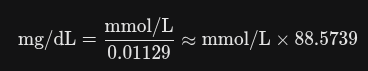

In [177]:
# REscate de datos usando trigliceridos_2
df_train['trigliceridos'] = df_train['trigliceridos'].fillna(df_train['trigliceridos_2'] * 88.57)
df_test['trigliceridos'] = df_test['trigliceridos'].fillna(df_test['trigliceridos_2'] * 88.57)

In [178]:
# # 1. Antes del rescate, veamos cuántos nulos tenemos
# nulos_trig_antes = df['trigliceridos'].isnull().sum()

# # 2. Rescatamos: Si trigliceridos es nulo, lo llenamos con (trigliceridos_2 * 88.57)
# # Usamos 88.57 que es el factor estándar de conversión para triglicéridos
# df['trigliceridos'] = df['trigliceridos'].fillna(df['trigliceridos_2'] * 88.57)

# # 3. Verificamos el impacto
# nulos_trig_despues = df['trigliceridos'].isnull().sum()
# print(f"Nulos en trigliceridos ANTES: {nulos_trig_antes}")
# print(f"Nulos en trigliceridos DESPUÉS: {nulos_trig_despues}")
# print(f"¡Rescatamos {nulos_trig_antes - nulos_trig_despues} registros!")

comparativa de métodos de imputación

In [179]:
df['trigliceridos'] = df['trigliceridos'].fillna(df['trigliceridos_2'] * 88.57)

# 1. Preparar datos
df_mediana = df.copy()
df_knn = df.copy()

# 2. Imputar con Mediana
df_mediana['trigliceridos'] = df_mediana['trigliceridos'].fillna(df_mediana['trigliceridos'].median())

# 3. Imputar con KNN
from sklearn.impute import KNNImputer
cols_para_knn = ['edad', 'genero', 'bmi', 'diabetes', 'trigliceridos']
imputer = KNNImputer(n_neighbors=5)
df_knn[cols_para_knn] = imputer.fit_transform(df_knn[cols_para_knn])

# 4. Comparativa Final
print("--- COMPARATIVA DE MÉTODOS ---")
print(f"ORIGINAL (con nulos)  | Media: {df['trigliceridos'].mean():.2f} | Std: {df['trigliceridos'].std():.2f}")
print(f"MÉTODO MEDIANA        | Media: {df_mediana['trigliceridos'].mean():.2f} | Std: {df_mediana['trigliceridos'].std():.2f}")
print(f"MÉTODO KNN            | Media: {df_knn['trigliceridos'].mean():.2f} | Std: {df_knn['trigliceridos'].std():.2f}")

--- COMPARATIVA DE MÉTODOS ---
ORIGINAL (con nulos)  | Media: 137.85 | Std: 113.67
MÉTODO MEDIANA        | Media: 134.63 | Std: 107.26
MÉTODO KNN            | Media: 137.84 | Std: 108.65


kNN es la mejor opcion para imputar el 11,57% restante

In [180]:
# Imputación
cols_for_trig_knn = ['edad', 'genero', 'bmi', 'diabetes', 'trigliceridos']
imputer_trig = KNNImputer(n_neighbors=5)

df_train[cols_for_trig_knn] = imputer_trig.fit_transform(df_train[cols_for_trig_knn])
df_test[cols_for_trig_knn] = imputer_trig.transform(df_test[cols_for_trig_knn])

df_train.drop(columns=['trigliceridos_2'], inplace=True, errors='ignore')
df_test.drop(columns=['trigliceridos_2'], inplace=True, errors='ignore')

print("Triglycerides imputation complete.")
print(f"Missing trigliceridos in df_train: {df_train['trigliceridos'].isnull().sum()}")
print(f"Missing trigliceridos in df_test: {df_test['trigliceridos'].isnull().sum()}")

Triglycerides imputation complete.
Missing trigliceridos in df_train: 0
Missing trigliceridos in df_test: 0


In [181]:
# # Eliminamos triglicéridos en mmol/L
# df.drop(columns=['trigliceridos_2'], inplace=True, errors='ignore')

###**HDL**

In [182]:
# 1. Comparamos los nulos de ambas columnas de HDL
print(f"Faltantes en HDL (hdl - mg/dL): {df['hdl'].isnull().sum()}")
print(f"Faltantes en HDL_2 (hdl_2 - mmol/L): {df['hdl_2'].isnull().sum()}")

# 2. Verificamos si hay casos donde hdl_2 puede 'salvar' a hdl
casos_recuperables_hdl = df[df['hdl'].isnull() & df['hdl_2'].notnull()].shape[0]
print(f"Casos donde hdl_2 podría 'salvar' a hdl: {casos_recuperables_hdl}")

Faltantes en HDL (hdl - mg/dL): 632
Faltantes en HDL_2 (hdl_2 - mmol/L): 632
Casos donde hdl_2 podría 'salvar' a hdl: 0


In [183]:
# 1. Guardamos stats actuales
stats_hdl_antes = {
    'media': df['hdl'].mean(),
    'std': df['hdl'].std()
}

# Incluimos género y bmi porque son los mejores predictores del hdl
cols_hdl_knn = ['genero', 'bmi', 'edad', 'hdl']
imputer_hdl = KNNImputer(n_neighbors=5)

# 3. Comparativa (en un df temporal)
df_hdl_knn = df.copy()
df_hdl_knn[cols_hdl_knn] = imputer_hdl.fit_transform(df_hdl_knn[cols_hdl_knn])

# 4. Resultados
print("--- AUDITORÍA DE IMPUTACIÓN HDL ---")
print(f"ORIGINAL | Media: {stats_hdl_antes['media']:.2f} | Std: {stats_hdl_antes['std']:.2f}")
print(f"POST KNN | Media: {df_hdl_knn['hdl'].mean():.2f} | Std: {df_hdl_knn['hdl'].std():.2f}")

--- AUDITORÍA DE IMPUTACIÓN HDL ---
ORIGINAL | Media: 53.26 | Std: 15.68
POST KNN | Media: 53.33 | Std: 15.13


Imputación con KNN

In [184]:
# # 1. Aplicamos el KNN definitivo
# from sklearn.impute import KNNImputer
# cols_hdl_knn = ['genero', 'bmi', 'edad', 'hdl']
# imputer_hdl = KNNImputer(n_neighbors=5)
# df[cols_hdl_knn] = imputer_hdl.fit_transform(df[cols_hdl_knn])

# # 2. Eliminamos la columna HDL_2
# df.drop(columns=['hdl_2'], inplace=True, errors='ignore')

In [185]:
cols_for_hdl_knn = ['genero', 'bmi', 'edad', 'hdl']
imputer_hdl = KNNImputer(n_neighbors=5)

df_train[cols_for_hdl_knn] = imputer_hdl.fit_transform(df_train[cols_for_hdl_knn])
df_test[cols_for_hdl_knn] = imputer_hdl.transform(df_test[cols_for_hdl_knn])

df_train.drop(columns=['hdl_2'], inplace=True, errors='ignore')
df_test.drop(columns=['hdl_2'], inplace=True, errors='ignore')

print("HDL imputation complete.")
print(f"Missing hdl in df_train: {df_train['hdl'].isnull().sum()}")
print(f"Missing hdl in df_test: {df_test['hdl'].isnull().sum()}")

HDL imputation complete.
Missing hdl in df_train: 0
Missing hdl in df_test: 0


###**COLESTEROL TOTAL**

Verificamos si podemos recuperar algo

In [186]:
# Rescue values using colesterol_total_2
df_train.loc[df_train['colesterol_total'].isnull() & df_train['colesterol_total_2'].notnull(), 'colesterol_total'] = \
    df_train.loc[df_train['colesterol_total'].isnull() & df_train['colesterol_total_2'].notnull(), 'colesterol_total_2'] / 0.02586
df_test.loc[df_test['colesterol_total'].isnull() & df_test['colesterol_total_2'].notnull(), 'colesterol_total'] = \
    df_test.loc[df_test['colesterol_total'].isnull() & df_test['colesterol_total_2'].notnull(), 'colesterol_total_2'] / 0.02586



In [187]:
# # 1. Verificamos si hay rescate posible
# casos_recuperables_col = df[df['colesterol_total'].isnull() & df['colesterol_total_2'].notnull()].shape[0]

# # 2. Rescatamos (si existen casos) y luego eliminamos la columna auxiliar
# if casos_recuperables_col > 0:
#     df['colesterol_total'] = df['colesterol_total'].fillna(df['colesterol_total_2'] / 0.02586)
#     print(f"¡Se rescataron {casos_recuperables_col} registros de Colesterol Total!")
# else:
#     print("No hubo casos para rescatar mediante conversión (los nulos coinciden).")

# # Eliminamos la columna _2 para mantener el df limpio
# df.drop(columns=['colesterol_total_2'], inplace=True, errors='ignore')

In [188]:
# Verificamos si hay rescate posible
casos_recuperables_col = df[df['colesterol_total'].isnull() & df['colesterol_total_2'].notnull()].shape[0]

# Rescatamos (si existen casos) y luego eliminamos la columna auxiliar
if casos_recuperables_col > 0:
    df['colesterol_total'] = df['colesterol_total'].fillna(df['colesterol_total_2'] / 0.02586)
    print(f"¡Se rescataron {casos_recuperables_col} registros de Colesterol Total!")
else:
    print("No hubo casos para rescatar mediante conversión (los nulos coinciden).")

# Guardamos el estado original (antes de imputar)
media_antes = df['colesterol_total'].mean()
std_antes = df['colesterol_total'].std()

# Aplicamos la imputación KNN
from sklearn.impute import KNNImputer
cols_col_knn = ['edad', 'genero', 'bmi', 'diabetes', 'colesterol_total']
imputer_col = KNNImputer(n_neighbors=5)
df[cols_col_knn] = imputer_col.fit_transform(df[cols_col_knn])

# 3. Calculamos el estado final
media_despues = df['colesterol_total'].mean()
std_despues = df['colesterol_total'].std()

# 4. Reporte de impacto
print("--- IMPACTO DE IMPUTACIÓN (COLESTEROL TOTAL) ---")
print(f"MEDIA:    Antes {media_antes:.2f} -> Después {media_despues:.2f} (Cambio: {((media_despues - media_antes)/media_antes)*100:.4f}%)")
print(f"DESV.EST: Antes {std_antes:.2f} -> Después {std_despues:.2f} (Cambio: {((std_despues - std_antes)/std_antes)*100:.4f}%)")
print(f"Nulos restantes: {df['colesterol_total'].isnull().sum()}")

No hubo casos para rescatar mediante conversión (los nulos coinciden).
--- IMPACTO DE IMPUTACIÓN (COLESTEROL TOTAL) ---
MEDIA:    Antes 188.08 -> Después 187.93 (Cambio: -0.0791%)
DESV.EST: Antes 41.29 -> Después 39.50 (Cambio: -4.3160%)
Nulos restantes: 0


In [189]:
# Impute using KNN
cols_for_chol_knn = ['edad', 'genero', 'bmi', 'diabetes', 'colesterol_total']
imputer_chol = KNNImputer(n_neighbors=5)

# Fit on df_train and transform both
df_train[cols_for_chol_knn] = imputer_chol.fit_transform(df_train[cols_for_chol_knn])
df_test[cols_for_chol_knn] = imputer_chol.transform(df_test[cols_for_chol_knn])

# Remove 'colesterol_total_2'
df_train.drop(columns=['colesterol_total_2'], inplace=True, errors='ignore')
df_test.drop(columns=['colesterol_total_2'], inplace=True, errors='ignore')

print("Colesterol Total imputation complete.")
print(f"Missing colesterol_total in df_train: {df_train['colesterol_total'].isnull().sum()}")
print(f"Missing colesterol_total in df_test: {df_test['colesterol_total'].isnull().sum()}")

Colesterol Total imputation complete.
Missing colesterol_total in df_train: 0
Missing colesterol_total in df_test: 0


In [190]:
# # Eliminamos la columna de unidades internacionales de Colesterol Total
# df.drop(columns=['colesterol_total_2'], inplace=True, errors='ignore')


###**LDL**

Como ya enemos los valores de colesterol total, hdl y trigliceridos, podemos calcular hdl usando la siguiente formula:
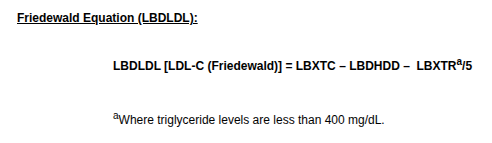

In [191]:
# 1. Función basada estrictamente en la documentación de NHANES
def rescatar_ldl_friedewald(row):
    # Si el LDL es nulo, aplicamos la fórmula oficial
    if pd.isnull(row['ldl']):
        # Verificamos la restricción técnica de Friedewald (TG < 400 mg/dL)
        if row['trigliceridos'] < 400:
            # Fórmula: Total - HDL - (TG / 5)
            return row['colesterol_total'] - row['hdl'] - (row['trigliceridos'] / 5)
    return row['ldl']

# 2. Aplicamos el rescate
nulos_antes = df['ldl'].isnull().sum()
df['ldl'] = df.apply(rescatar_ldl_friedewald, axis=1)
nulos_despues = df['ldl'].isnull().sum()

# 3. Limpieza de columnas sobrantes
df.drop(columns=['ldl_2'], inplace=True, errors='ignore')

print("--- RESULTADO DEL RESCATE SEGÚN DOCUMENTACIÓN ---")
print(f"Nulos iniciales en LDL: {nulos_antes}")
print(f"Nulos después de aplicar Friedewald: {nulos_despues}")
print(f"¡Logramos rescatar {nulos_antes - nulos_despues} pacientes!")

--- RESULTADO DEL RESCATE SEGÚN DOCUMENTACIÓN ---
Nulos iniciales en LDL: 3200
Nulos después de aplicar Friedewald: 780
¡Logramos rescatar 2420 pacientes!


Restante con KNN

In [192]:
# 1. Definión función para cálculo Friedewald formula for rescue
def rescatar_ldl_friedewald(row):
    # Only calculate if 'ldl' is null and Friedewald conditions are met
    if pd.isnull(row['ldl']):
        if row['trigliceridos'] < 400:
            return row['colesterol_total'] - row['hdl'] - (row['trigliceridos'] / 5)
    return row['ldl']

# Se aplica Friedewald para rescatar df_train y df_test
df_train['ldl'] = df_train.apply(rescatar_ldl_friedewald, axis=1)
df_test['ldl'] = df_test.apply(rescatar_ldl_friedewald, axis=1)

# Imputación con KNN
cols_for_ldl_knn = ['edad', 'genero', 'bmi', 'diabetes', 'trigliceridos', 'hdl', 'colesterol_total', 'ldl']
imputer_ldl = KNNImputer(n_neighbors=5)


df_train[cols_for_ldl_knn] = imputer_ldl.fit_transform(df_train[cols_for_ldl_knn])
df_test[cols_for_ldl_knn] = imputer_ldl.transform(df_test[cols_for_ldl_knn])

df_train.drop(columns=['ldl_2'], inplace=True, errors='ignore')
df_test.drop(columns=['ldl_2'], inplace=True, errors='ignore')

print("LDL imputation complete.")
print(f"Missing ldl in df_train: {df_train['ldl'].isnull().sum()}")
print(f"Missing ldl in df_test: {df_test['ldl'].isnull().sum()}")

LDL imputation complete.
Missing ldl in df_train: 0
Missing ldl in df_test: 0


In [193]:
# # 1. Definimos las columnas para el cierre final de lípidos
# cols_ldl_knn = ['edad', 'genero', 'bmi', 'diabetes', 'trigliceridos', 'hdl', 'colesterol_total', 'ldl']

# # 2. Aplicamos el KNN final
# imputer_ldl = KNNImputer(n_neighbors=5)
# df[cols_ldl_knn] = imputer_ldl.fit_transform(df[cols_ldl_knn])

# print(f"--- CIERRE FINAL DE LÍPIDOS ---")
# print(f"Nulos restantes en LDL: {df['ldl'].isnull().sum()}")
# print(f"Dataset de lípidos completado al 100%.")

### **GLUCOSA (a revisar)**

--- ANÁLISIS DE CORRELACIÓN ---
Correlación entre glucosa (mg/dL) y glucosa_2 (mmol/L): 1.0000


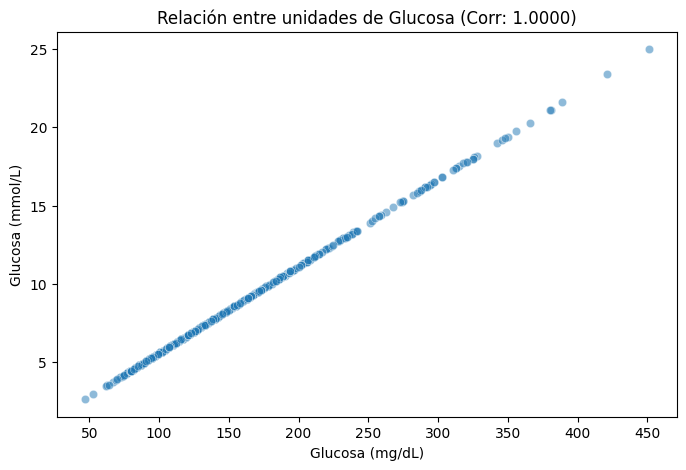

In [194]:
# Calculamos la correlación de Pearson entre ambas glucosas
correlacion = df[['glucosa', 'glucosa_2']].corr().iloc[0, 1]

print(f"--- ANÁLISIS DE CORRELACIÓN ---")
print(f"Correlación entre glucosa (mg/dL) y glucosa_2 (mmol/L): {correlacion:.4f}")

# Visualización rápida para confirmar linealidad
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='glucosa', y='glucosa_2', alpha=0.5)
plt.title(f'Relación entre unidades de Glucosa (Corr: {correlacion:.4f})')
plt.xlabel('Glucosa (mg/dL)')
plt.ylabel('Glucosa (mmol/L)')
plt.show()

In [195]:
# Factor de conversión Roche cobas c systems
FACTOR_ROCHE = 18.02

# Solo llenamos si 'glucosa' es nulo y 'glucosa_2' tiene datos
df['glucosa'] = df['glucosa'].fillna(df['glucosa_2'] * FACTOR_ROCHE)

# Eliminamos la columna espejo para no confundir al modelo con dos variables idénticas
df.drop(columns=['glucosa_2'], inplace=True, errors='ignore')

print(f"Nulos en glucosa tras consolidación: {df['glucosa'].isnull().sum()}")

Nulos en glucosa tras consolidación: 3133


In [196]:
FACTOR_ROCHE = 18.02

df_train['glucosa'] = df_train['glucosa'].fillna(df_train['glucosa_2'] * FACTOR_ROCHE)
df_test['glucosa'] = df_test['glucosa'].fillna(df_test['glucosa_2'] * FACTOR_ROCHE)

df_train.drop(columns=['glucosa_2'], inplace=True, errors='ignore')
df_test.drop(columns=['glucosa_2'], inplace=True, errors='ignore')

print("Glucosa consolidation complete.")
print(f"Missing glucosa in df_train: {df_train['glucosa'].isnull().sum()}")
print(f"Missing glucosa in df_test: {df_test['glucosa'].isnull().sum()}")

Glucosa consolidation complete.
Missing glucosa in df_train: 2507
Missing glucosa in df_test: 626


NO se pudieron rescdartar muchos datos. El faltante es grande. Se usará en su lugar Glicohemoglobinan que  es una proteína presente en glóbulos rojos que tiene azúcar pegada

In [197]:
# # 1. Seleccionamos variables relacionadas con el azúcar a largo plazo
# cols_glico = ['edad', 'bmi', 'diabetes', 'glicohemoglobina']

# # 2. Aplicamos KNN (5 vecinos)
# imputer_glico = KNNImputer(n_neighbors=5)
# df[cols_glico] = imputer_glico.fit_transform(df[cols_glico])

# print("--- CIERRE DE GLICOHEMOGLOBINA ---")
# print(f"Nulos restantes: {df['glicohemoglobina'].isnull().sum()}")
# print(f"Media de la población: {df['glicohemoglobina'].mean():.2f}%")

In [198]:
cols_for_glico_knn = ['edad', 'bmi', 'diabetes', 'glicohemoglobina']
imputer_glico = KNNImputer(n_neighbors=5)

df_train[cols_for_glico_knn] = imputer_glico.fit_transform(df_train[cols_for_glico_knn])
df_test[cols_for_glico_knn] = imputer_glico.transform(df_test[cols_for_glico_knn])

print("Glicohemoglobina imputation complete.")
print(f"Missing glicohemoglobina in df_train: {df_train['glicohemoglobina'].isnull().sum()}")
print(f"Missing glicohemoglobina in df_test: {df_test['glicohemoglobina'].isnull().sum()}")

Glicohemoglobina imputation complete.
Missing glicohemoglobina in df_train: 0
Missing glicohemoglobina in df_test: 0


### **HEMOGLOBINA**

In [199]:
# 1. Verificamos nulos iniciales
nulos_hemo = df['hemoglobina'].isnull().sum()
print(f"Nulos iniciales en Hemoglobina: {nulos_hemo}")

# 2. Imputación KNN
# Incluimos genero y edad porque la hemoglobina depende directamente de ellos
cols_hemo = ['genero', 'edad', 'hemoglobina']
imputer_hemo = KNNImputer(n_neighbors=5)

df[cols_hemo] = imputer_hemo.fit_transform(df[cols_hemo])

# 3. Reporte
print(f"--- CIERRE DE HEMOGLOBINA ---")
print(f"Nulos finales: {df['hemoglobina'].isnull().sum()}")
print(f"Rango de valores: {df['hemoglobina'].min():.1f} - {df['hemoglobina'].max():.1f} g/dL")

Nulos iniciales en Hemoglobina: 541
--- CIERRE DE HEMOGLOBINA ---
Nulos finales: 0
Rango de valores: 6.4 - 19.9 g/dL


In [200]:
cols_for_hemo_knn = ['genero', 'edad', 'hemoglobina']
imputer_hemo = KNNImputer(n_neighbors=5)

df_train[cols_for_hemo_knn] = imputer_hemo.fit_transform(df_train[cols_for_hemo_knn])
df_test[cols_for_hemo_knn] = imputer_hemo.transform(df_test[cols_for_hemo_knn])

print("Hemoglobina imputation complete.")
print(f"Missing hemoglobina in df_train: {df_train['hemoglobina'].isnull().sum()}")
print(f"Missing hemoglobina in df_test: {df_test['hemoglobina'].isnull().sum()}")

Hemoglobina imputation complete.
Missing hemoglobina in df_train: 0
Missing hemoglobina in df_test: 0


### **PROTEINA C**

In [201]:
# # 1. Variables que explican la Proteína C (Inflamación)
# # El BMI es fundamental aquí.
# cols_pc = ['bmi', 'edad', 'proteina_c']

# imputer_pc = KNNImputer(n_neighbors=5)

# # Aplicamos
# df[cols_pc] = imputer_pc.fit_transform(df[cols_pc])

# print(f"--- CIERRE DE PROTEINA_C ---")
# print(f"Nulos finales: {df['proteina_c'].isnull().sum()}")
# print(f"Media resultante: {df['proteina_c'].mean():.2f} mg/L")

In [202]:
cols_for_pc_knn = ['bmi', 'edad', 'proteina_c']
imputer_pc = KNNImputer(n_neighbors=5)

df_train[cols_for_pc_knn] = imputer_pc.fit_transform(df_train[cols_for_pc_knn])
df_test[cols_for_pc_knn] = imputer_pc.transform(df_test[cols_for_pc_knn])

print("Proteina C imputation complete.")
print(f"Missing proteina_c in df_train: {df_train['proteina_c'].isnull().sum()}")
print(f"Missing proteina_c in df_test: {df_test['proteina_c'].isnull().sum()}")

Proteina C imputation complete.
Missing proteina_c in df_train: 0
Missing proteina_c in df_test: 0


### **CREATININA**

In [203]:
# # 1. Variables predictoras: Género, Edad y BMI (reflejo indirecto de masa corporal)
# cols_creat = ['genero', 'edad', 'bmi', 'creatinina']

# # 2. Configurar e imputar
# imputer_creat = KNNImputer(n_neighbors=5)
# df[cols_creat] = imputer_creat.fit_transform(df[cols_creat])

# print(f"--- REPORTE CREATININA ---")
# print(f"Nulos finales: {df['creatinina'].isnull().sum()}")
# print(f"Rango: {df['creatinina'].min():.2f} - {df['creatinina'].max():.2f} mg/dL")

In [204]:
cols_for_creat_knn = ['genero', 'edad', 'bmi', 'creatinina']
imputer_creat = KNNImputer(n_neighbors=5)

df_train[cols_for_creat_knn] = imputer_creat.fit_transform(df_train[cols_for_creat_knn])
df_test[cols_for_creat_knn] = imputer_creat.transform(df_test[cols_for_creat_knn])

print("Creatinina imputation complete.")
print(f"Missing creatinina in df_train: {df_train['creatinina'].isnull().sum()}")
print(f"Missing creatinina in df_test: {df_test['creatinina'].isnull().sum()}")

Creatinina imputation complete.
Missing creatinina in df_train: 0
Missing creatinina in df_test: 0


### **HORAS DE SUEÑO**

In [205]:
# Revisamos los valores únicos y la frecuencia
print("Distribución de horas de sueño:")
print(df['horas_suenio'].value_counts().sort_index())

# Vemos la mediana general
print(f"\nMediana general: {df['horas_suenio'].median()}")

Distribución de horas de sueño:
horas_suenio
2.0       27
3.0       34
3.5       23
4.0      102
4.5       49
5.0      214
5.5      123
6.0      475
6.5      346
7.0      912
7.5      500
8.0     1054
8.5      366
9.0      652
9.5      157
10.0     227
10.5      61
11.0     106
11.5      16
12.0      41
12.5       5
13.0      19
13.5       1
14.0      12
Name: count, dtype: int64

Mediana general: 7.5


In [206]:
# # Imputación
# mediana_suenio = df['horas_suenio'].median()
# df['horas_suenio'] = df['horas_suenio'].fillna(mediana_suenio)

# print(f"Se imputaron los nulos con el valor: {mediana_suenio} horas")
# print(f"Nulos restantes: {df['horas_suenio'].isnull().sum()}")

In [207]:
median_horas_suenio_train = df_train['horas_suenio'].median()
df_train['horas_suenio'] = df_train['horas_suenio'].fillna(median_horas_suenio_train)
df_test['horas_suenio'] = df_test['horas_suenio'].fillna(median_horas_suenio_train)

print("Horas Suenio imputation complete.")
print(f"Missing horas_suenio in df_train: {df_train['horas_suenio'].isnull().sum()}")
print(f"Missing horas_suenio in df_test: {df_test['horas_suenio'].isnull().sum()}")

Horas Suenio imputation complete.
Missing horas_suenio in df_train: 0
Missing horas_suenio in df_test: 0


### **ANCHO DE DISTRIBUCIÓN DE GLÓBULOS ROJOS**

In [208]:
# # Usamos las variables sanguíneas que ya tenemos completas para predecir el RDW
# cols_rdw = ['hemoglobina', 'proteina_c', 'ancho_distribucion_globulos']

# imputer_rdw = KNNImputer(n_neighbors=5)
# df[cols_rdw] = imputer_rdw.fit_transform(df[cols_rdw])

# print("--- CIERRE DE RDW ---")
# print(f"Nulos restantes: {df['ancho_distribucion_globulos'].isnull().sum()}")

In [209]:
cols_for_rdw_knn = ['hemoglobina', 'proteina_c', 'ancho_distribucion_globulos']
imputer_rdw = KNNImputer(n_neighbors=5)

df_train[cols_for_rdw_knn] = imputer_rdw.fit_transform(df_train[cols_for_rdw_knn])
df_test[cols_for_rdw_knn] = imputer_rdw.transform(df_test[cols_for_rdw_knn])

print("Ancho Distribucion Globulos imputation complete.")
print(f"Missing ancho_distribucion_globulos in df_train: {df_train['ancho_distribucion_globulos'].isnull().sum()}")
print(f"Missing ancho_distribucion_globulos in df_test: {df_test['ancho_distribucion_globulos'].isnull().sum()}")

Ancho Distribucion Globulos imputation complete.
Missing ancho_distribucion_globulos in df_train: 0
Missing ancho_distribucion_globulos in df_test: 0


### **consumo_alcohol_ultimo_año**

In [210]:
print(df['consumo_alcohol_ultimo_año'].value_counts().sort_index())

consumo_alcohol_ultimo_año
0.0     1034
1.0      142
2.0      154
3.0      270
4.0      317
5.0      331
6.0      568
7.0      333
8.0      281
9.0      444
10.0     496
Name: count, dtype: int64


In [211]:
# Ver qué valores existen
print("Distribución original de consumo_alcohol:")
print(df['consumo_alcohol_ultimo_año'].value_counts().sort_index())

Distribución original de consumo_alcohol:
consumo_alcohol_ultimo_año
0.0     1034
1.0      142
2.0      154
3.0      270
4.0      317
5.0      331
6.0      568
7.0      333
8.0      281
9.0      444
10.0     496
Name: count, dtype: int64


In [212]:
# 1. Ver el cruce de las dos variables incluyendo los nulos (NaN)
print("--- MATRIZ DE CONSISTENCIA DE ALCOHOL ---")
print(pd.crosstab(df['bebio_alguna_vez'], df['consumo_alcohol_ultimo_año'], dropna=False))

# 2. Calcular cuántos nulos en 'bebio_alguna_vez' tienen datos de consumo
rescatables = df[df['bebio_alguna_vez'].isnull() & df['consumo_alcohol_ultimo_año'].notnull()].shape[0]

print(f"\nCasos donde 'bebio_alguna_vez' es nulo pero SÍ hay frecuencia de consumo: {rescatables}")

--- MATRIZ DE CONSISTENCIA DE ALCOHOL ---
consumo_alcohol_ultimo_año  0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   \
bebio_alguna_vez                                                             
1.0                         1034   142   154   270   317   331   568   333   
2.0                            0     0     0     0     0     0     0     0   
NaN                            0     0     0     0     0     0     0     0   

consumo_alcohol_ultimo_año  8.0   9.0   10.0  NaN   
bebio_alguna_vez                                    
1.0                          281   444   496     4  
2.0                            0     0     0   509  
NaN                            0     0     0   685  

Casos donde 'bebio_alguna_vez' es nulo pero SÍ hay frecuencia de consumo: 0


Primero a los que respondieron en bebio_alguna_vez con 2 (nunca), se les asigna en consumo_alcohol_ultimo_año = 0 (no bebió nunca en el último año)

In [213]:
# # Asignamos frecuencia 0 a los que respondieron que NO bebieron nunca
# df.loc[df['bebio_alguna_vez'] == 2.0, 'consumo_alcohol_ultimo_año'] = 0.0

# # Verificamos cómo quedó la columna ahora
# print("Nueva distribución de consumo_alcohol_ultimo_año:")
# print(df['consumo_alcohol_ultimo_año'].value_counts(dropna=False).sort_index())

# # Contamos cuántos nulos (NaN) sobreviven
# nulos_finales = df['consumo_alcohol_ultimo_año'].isnull().sum()
# print(f"\nFaltantes restantes después de la lógica: {nulos_finales}")

In [214]:
# 14. Handle Consumo Alcohol Ultimo Año
# Asigno 0.0 donde 'bebio_alguna_vez' is 2.0
df_train.loc[df_train['bebio_alguna_vez'] == 2.0, 'consumo_alcohol_ultimo_año'] = 0.0
df_test.loc[df_test['bebio_alguna_vez'] == 2.0, 'consumo_alcohol_ultimo_año'] = 0.0

# Limpiar 77/99
# df_train['consumo_alcohol_ultimo_año'] = df_train['consumo_alcohol_ultimo_año'].replace({77.0: np.nan, 99.0: np.nan})
# df_test['consumo_alcohol_ultimo_año'] = df_test['consumo_alcohol_ultimo_año'].replace({77.0: np.nan, 99.0: np.nan})

Comparativa de imputación con mediana y con knn

In [215]:
# 1. Preparar datos: Limpiar 77/99 y crear copias para comparar
df_temp = df.copy()
df_temp['consumo_alcohol_ultimo_año'] = df_temp['consumo_alcohol_ultimo_año'].replace({77.0: np.nan, 99.0: np.nan})

# --- OPCIÓN A: MEDIANA ---
serie_mediana = df_temp['consumo_alcohol_ultimo_año'].fillna(df_temp['consumo_alcohol_ultimo_año'].median())

# --- OPCIÓN B: KNN ---
imputer = KNNImputer(n_neighbors=5)
# Usamos edad y genero (asegúrate de que genero sea numérico) para el KNN
columnas_knn = ['genero', 'edad', 'consumo_alcohol_ultimo_año']
df_knn = pd.DataFrame(imputer.fit_transform(df_temp[columnas_knn]), columns=columnas_knn)
serie_knn = df_knn['consumo_alcohol_ultimo_año'].round()

# 2. COMPARATIVA
comparativa = pd.DataFrame({
    'Original (con nulos)': df_temp['consumo_alcohol_ultimo_año'].describe(),
    'Imputación Mediana': serie_mediana.describe(),
    'Imputación KNN': serie_knn.describe()
})

print("--- COMPARATIVA DE ESTADÍSTICAS ---")
print(comparativa)

print("\n--- DIFERENCIA EN DISTRIBUCIÓN (Conteos) ---")
print("Mediana:\n", serie_mediana.value_counts().head(3))
print("\nKNN:\n", serie_knn.value_counts().head(3))

--- COMPARATIVA DE ESTADÍSTICAS ---
       Original (con nulos)  Imputación Mediana  Imputación KNN
count           4370.000000         5568.000000     5568.000000
mean               4.834325            4.869971        4.893858
std                3.538949            3.135863        3.243162
min                0.000000            0.000000        0.000000
25%                1.000000            3.000000        3.000000
50%                5.000000            5.000000        5.000000
75%                8.000000            7.000000        7.000000
max               10.000000           10.000000       10.000000

--- DIFERENCIA EN DISTRIBUCIÓN (Conteos) ---
Mediana:
 consumo_alcohol_ultimo_año
5.0    1529
0.0    1034
6.0     568
Name: count, dtype: int64

KNN:
 consumo_alcohol_ultimo_año
0.0    1042
6.0     789
5.0     566
Name: count, dtype: int64


In [216]:
# # 1. Limpieza de códigos de error antes de imputar
# df['consumo_alcohol_ultimo_año'] = df['consumo_alcohol_ultimo_año'].replace({77.0: np.nan, 99.0: np.nan})

# # 2. Configuramos el KNNImputer
# # Usamos género y edad como variables de contexto para "predecir" el alcohol
# imputer_alc = KNNImputer(n_neighbors=5)
# cols_alc = ['genero', 'edad', 'bmi', 'consumo_alcohol_ultimo_año']

# # 3. Aplicamos la imputación
# df[cols_alc] = imputer_alc.fit_transform(df[cols_alc])

# # 4. Redondeamos el resultado para mantener la escala original (0 a 10)
# df['consumo_alcohol_ultimo_año'] = df['consumo_alcohol_ultimo_año'].round()

# print("--- CIERRE DE VARIABLE: ALCOHOL ---")
# print(f"Nulos finales: {df['consumo_alcohol_ultimo_año'].isnull().sum()}")
# print(f"Media final: {df['consumo_alcohol_ultimo_año'].mean():.2f}")

In [217]:

cols_for_alc_knn = ['genero', 'edad', 'bmi', 'consumo_alcohol_ultimo_año']
imputer_alc = KNNImputer(n_neighbors=5)

df_train[cols_for_alc_knn] = imputer_alc.fit_transform(df_train[cols_for_alc_knn])
df_test[cols_for_alc_knn] = imputer_alc.transform(df_test[cols_for_alc_knn])

df_train['consumo_alcohol_ultimo_año'] = df_train['consumo_alcohol_ultimo_año'].round()
df_test['consumo_alcohol_ultimo_año'] = df_test['consumo_alcohol_ultimo_año'].round()

print("Consumo Alcohol Ultimo Año imputation complete.")
print(f"Missing consumo_alcohol_ultimo_año in df_train: {df_train['consumo_alcohol_ultimo_año'].isnull().sum()}")
print(f"Missing consumo_alcohol_ultimo_año in df_test: {df_test['consumo_alcohol_ultimo_año'].isnull().sum()}")

Consumo Alcohol Ultimo Año imputation complete.
Missing consumo_alcohol_ultimo_año in df_train: 0
Missing consumo_alcohol_ultimo_año in df_test: 0


### **consumo_excesivo_alcohol_ultimo_año**

A los que respondieron que no bebieron nunca en el último año se les asigna 0

In [218]:
# # Si en la frecuencia del último año es 0.0 (Nunca),
# # entonces el consumo excesivo también es 0.0
# df.loc[df['consumo_alcohol_ultimo_año'] == 0.0, 'consumo_excesivo_alcohol_ultimo_año'] = 0.0

# print("Faltantes después de aplicar lógica de arrastre:")
# print(df['consumo_excesivo_alcohol_ultimo_año'].isnull().sum())

# # 1. Limpiar códigos de error (777, 999) si existieran
# df['consumo_excesivo_alcohol_ultimo_año'] = df['consumo_excesivo_alcohol_ultimo_año'].replace({777: np.nan, 999: np.nan, 77: np.nan, 99: np.nan})

# # 2. Configurar KNN usando la frecuencia de alcohol como apoyo clave
# imputer_binge = KNNImputer(n_neighbors=5)
# # Incluimos las variables que tienen relación lógica
# cols_binge = ['edad', 'genero', 'consumo_alcohol_ultimo_año', 'consumo_excesivo_alcohol_ultimo_año']

# # 3. Imputar
# df[cols_binge] = imputer_binge.fit_transform(df[cols_binge])

# # 4. Redondear (ya que hablamos de cantidad de días, no pueden ser decimales)
# df['consumo_excesivo_alcohol_ultimo_año'] = df['consumo_excesivo_alcohol_ultimo_año'].round()

# print(f"Nulos finales en consumo excesivo: {df['consumo_excesivo_alcohol_ultimo_año'].isnull().sum()}")

In [219]:

# Se asigna 0.0 donde 'consumo_alcohol_ultimo_año' es 0.0
df_train.loc[df_train['consumo_alcohol_ultimo_año'] == 0.0, 'consumo_excesivo_alcohol_ultimo_año'] = 0.0
df_test.loc[df_test['consumo_alcohol_ultimo_año'] == 0.0, 'consumo_excesivo_alcohol_ultimo_año'] = 0.0

# df_train['consumo_excesivo_alcohol_ultimo_año'] = df_train['consumo_excesivo_alcohol_ultimo_año'].replace({777: np.nan, 999: np.nan, 77: np.nan, 99: np.nan})
# df_test['consumo_excesivo_alcohol_ultimo_año'] = df_test['consumo_excesivo_alcohol_ultimo_año'].replace({777: np.nan, 999: np.nan, 77: np.nan, 99: np.nan})

# Imputación
cols_for_binge_knn = ['edad', 'genero', 'consumo_alcohol_ultimo_año', 'consumo_excesivo_alcohol_ultimo_año']
imputer_binge = KNNImputer(n_neighbors=5)

df_train[cols_for_binge_knn] = imputer_binge.fit_transform(df_train[cols_for_binge_knn])
df_test[cols_for_binge_knn] = imputer_binge.transform(df_test[cols_for_binge_knn])

df_train['consumo_excesivo_alcohol_ultimo_año'] = df_train['consumo_excesivo_alcohol_ultimo_año'].round()
df_test['consumo_excesivo_alcohol_ultimo_año'] = df_test['consumo_excesivo_alcohol_ultimo_año'].round()

print("Consumo Excesivo Alcohol Ultimo Año imputation complete.")
print(f"Missing consumo_excesivo_alcohol_ultimo_año in df_train: {df_train['consumo_excesivo_alcohol_ultimo_año'].isnull().sum()}")
print(f"Missing consumo_excesivo_alcohol_ultimo_año in df_test: {df_test['consumo_excesivo_alcohol_ultimo_año'].isnull().sum()}")

Consumo Excesivo Alcohol Ultimo Año imputation complete.
Missing consumo_excesivo_alcohol_ultimo_año in df_train: 0
Missing consumo_excesivo_alcohol_ultimo_año in df_test: 0


### **deprimido_decaido**

In [220]:
print(df['deprimido_decaido'].value_counts().sort_index())

deprimido_decaido
0.0    3673
1.0     793
2.0     212
3.0     164
Name: count, dtype: int64


In [221]:
# 1. LIMPIEZA: Reemplazamos los códigos de error (7 y 9) en AMBOS datasets
# df_train['deprimido_decaido'] = df_train['deprimido_decaido'].replace({7: np.nan, 9: np.nan, 7.0: np.nan, 9.0: np.nan})
# df_test['deprimido_decaido'] = df_test['deprimido_decaido'].replace({7: np.nan, 9: np.nan, 7.0: np.nan, 9.0: np.nan})

# 2. DEFINICIÓN DE COLUMNAS: Variables para que el KNN "entienda" al paciente
# (Asegúrate de que 'edad', 'genero' y 'bmi' estén en tus dataframes)
cols_depre = ['edad', 'genero', 'bmi', 'deprimido_decaido']

# 3. CONFIGURACIÓN DEL IMPUTER
imputer_depre = KNNImputer(n_neighbors=5)

# 4. FIT & TRANSFORM en TRAIN
# Aquí el algoritmo aprende los patrones de deprimido_decaido basándose en edad/genero/bmi
df_train[cols_depre] = imputer_depre.fit_transform(df_train[cols_depre])

# 5. SOLO TRANSFORM en TEST
# Muy importante: Usamos las "reglas" aprendidas en Train para completar Test
df_test[cols_depre] = imputer_depre.transform(df_test[cols_depre])

# # 6. REDONDEO: Como la escala es 0, 1, 2, 3 (valores enteros)
# df_train['deprimido_decaido'] = df_train['deprimido_decaido'].round()
# df_test['deprimido_decaido'] = df_test['deprimido_decaido'].round()

print("Imputación de 'deprimido_decaido' finalizada en Train y Test.")
print(f"Nulos en Train: {df_train['deprimido_decaido'].isnull().sum()}")
print(f"Nulos en Test: {df_test['deprimido_decaido'].isnull().sum()}")

Imputación de 'deprimido_decaido' finalizada en Train y Test.
Nulos en Train: 0
Nulos en Test: 0


### **ANHEDONIA**

In [222]:
# Análisis previo para df_train
print("--- ANÁLISIS DE ANHEDONIA (Train) ---")
conteo_train = df_train['anhedonia'].value_counts(dropna=False).sort_index()
print(conteo_train)

# Análisis previo para df_test
print("\n--- ANÁLISIS DE ANHEDONIA (Test) ---")
conteo_test = df_test['anhedonia'].value_counts(dropna=False).sort_index()
print(conteo_test)

# Cálculo de porcentajes de "basura" o nulos
total_nulos_err = df_train['anhedonia'].isin([7, 9, 7.0, 9.0]).sum() + df_train['anhedonia'].isnull().sum()
porcentaje = (total_nulos_err / len(df_train)) * 100
print(f"\nTotal de datos a imputar en Train (Nulos + Errores): {total_nulos_err} ({porcentaje:.2f}%)")

--- ANÁLISIS DE ANHEDONIA (Train) ---
anhedonia
0.0    2866
1.0     621
2.0     218
3.0     162
NaN     587
Name: count, dtype: int64

--- ANÁLISIS DE ANHEDONIA (Test) ---
anhedonia
0.0    745
1.0    153
2.0     47
3.0     30
NaN    139
Name: count, dtype: int64

Total de datos a imputar en Train (Nulos + Errores): 587 (13.18%)


In [223]:
# 1. Limpiamos los códigos de error detectados (7 y 9) en AMBOS datasets
# df_train['anhedonia'] = df_train['anhedonia'].replace({7.0: np.nan, 9.0: np.nan})
# df_test['anhedonia'] = df_test['anhedonia'].replace({7.0: np.nan, 9.0: np.nan})

# 2. Preparamos las columnas para el KNN
# Nota: Usamos 'deprimido_decaido' porque ya la tenemos limpia e imputada,
# y es la que más información aporta sobre la anhedonia.
cols_anh = ['edad', 'genero', 'bmi', 'deprimido_decaido', 'anhedonia']

imputer_anh = KNNImputer(n_neighbors=5)

# 3. FIT y TRANSFORM en Train
df_train[cols_anh] = imputer_anh.fit_transform(df_train[cols_anh])

# 4. SOLO TRANSFORM en Test
df_test[cols_anh] = imputer_anh.transform(df_test[cols_anh])

# 5. Redondeo para mantener la escala original de 0 a 3
df_train['anhedonia'] = df_train['anhedonia'].round()
df_test['anhedonia'] = df_test['anhedonia'].round()

print("Imputación de anhedonia completada.")
print(f"Valores finales en Train:\n{df_train['anhedonia'].value_counts().sort_index()}")

Imputación de anhedonia completada.
Valores finales en Train:
anhedonia
0.0    3294
1.0     775
2.0     223
3.0     162
Name: count, dtype: int64


### **prediabetes_glucosa_alterada**

In [224]:
# Análisis previo en Train y Test
print("--- ANÁLISIS DE PREDIABETES (Train) ---")
print(df_train['prediabetes_glucosa_alterada'].value_counts(dropna=False).sort_index())

print("\n--- ANÁLISIS DE PREDIABETES (Test) ---")
print(df_test['prediabetes_glucosa_alterada'].value_counts(dropna=False).sort_index())

--- ANÁLISIS DE PREDIABETES (Train) ---
prediabetes_glucosa_alterada
1.0     473
2.0    3139
NaN     842
Name: count, dtype: int64

--- ANÁLISIS DE PREDIABETES (Test) ---
prediabetes_glucosa_alterada
1.0     98
2.0    804
NaN    212
Name: count, dtype: int64


In [225]:
# 1. Limpieza del código de error (9.0: No sabe)
# df_train['prediabetes_glucosa_alterada'] = df_train['prediabetes_glucosa_alterada'].replace({9.0: np.nan})
# df_test['prediabetes_glucosa_alterada'] = df_test['prediabetes_glucosa_alterada'].replace({9.0: np.nan})

# 2. Definimos las variables de apoyo
# Incluimos BMI y Edad porque son los "padres" de la glucosa alterada
cols_pre = ['edad', 'bmi', 'prediabetes_glucosa_alterada']

imputer_pre = KNNImputer(n_neighbors=5)

# 3. FIT y TRANSFORM en Train
df_train[cols_pre] = imputer_pre.fit_transform(df_train[cols_pre])

# 4. SOLO TRANSFORM en Test
df_test[cols_pre] = imputer_pre.transform(df_test[cols_pre])

# 5. Redondeo (Para volver a 1.0 o 2.0)
df_train['prediabetes_glucosa_alterada'] = df_train['prediabetes_glucosa_alterada'].round()
df_test['prediabetes_glucosa_alterada'] = df_test['prediabetes_glucosa_alterada'].round()

print("Imputación de prediabetes finalizada.")
print(f"Distribución final en Train:\n{df_train['prediabetes_glucosa_alterada'].value_counts()}")

Imputación de prediabetes finalizada.
Distribución final en Train:
prediabetes_glucosa_alterada
2.0    3927
1.0     527
Name: count, dtype: int64


### **FUMADOR ACTUAL**

In [226]:
# Análisis previo en Train y Test
print("--- ANÁLISIS DE FUMADOR_ACTUAL (Train) ---")
print(df_train['fumador_actual'].value_counts(dropna=False).sort_index())

print("\n--- ANÁLISIS DE FUMADOR_ACTUAL (Test) ---")
print(df_test['fumador_actual'].value_counts(dropna=False).sort_index())

--- ANÁLISIS DE FUMADOR_ACTUAL (Train) ---
fumador_actual
1.0     633
2.0     173
3.0    1057
NaN    2591
Name: count, dtype: int64

--- ANÁLISIS DE FUMADOR_ACTUAL (Test) ---
fumador_actual
1.0    162
2.0     37
3.0    272
NaN    643
Name: count, dtype: int64


se revisa que si respondieron 2, no diga que sea fumador actual.

In [227]:
# Creamos una tabla cruzada para ver cómo se relacionan
cruce_tabaco = pd.crosstab(
    df_train['fumo_100_cigarrillos'],
    df_train['fumador_actual'],
    dropna=False
)

print("--- TABLA DE CONSISTENCIA DE TABACO ---")
print(cruce_tabaco)

# Buscamos específicamente el "error": Gente que dijo NO (2.0) pero tiene un valor de fumador (1.0 o 2.0)
errores = df_train[(df_train['fumo_100_cigarrillos'] == 2.0) & (df_train['fumador_actual'].isin([1.0, 2.0]))]

if len(errores) > 0:
    print(f"\n¡Atención! Se encontraron {len(errores)} casos contradictorios.")
    print(errores[['fumo_100_cigarrillos', 'fumador_actual']].head())
else:
    print("\n¡Todo perfecto! No hay contradicciones: los que dijeron 'No' son todos No Fumadores (3.0).")

--- TABLA DE CONSISTENCIA DE TABACO ---
fumador_actual        1.0  2.0   3.0   NaN
fumo_100_cigarrillos                      
1.0                   633  173  1057     0
2.0                     0    0     0  2591

¡Todo perfecto! No hay contradicciones: los que dijeron 'No' son todos No Fumadores (3.0).


en NHANES la variable fumador_actual queda vacía para todos aquellos que respondieron "No" (2.0) a fumo_100_cigarrillos

In [228]:
# Aplicamos la lógica: Si no fumó 100 cigarrillos, NO es fumador actual (3.0)
df_train.loc[(df_train['fumador_actual'].isnull()) & (df_train['fumo_100_cigarrillos'] == 2.0), 'fumador_actual'] = 3.0
df_test.loc[(df_test['fumador_actual'].isnull()) & (df_test['fumo_100_cigarrillos'] == 2.0), 'fumador_actual'] = 3.0

print(f"Nulos en Train después del rescate: {df_train['fumador_actual'].isnull().sum()}")

Nulos en Train después del rescate: 0


### **actividad_deportiva_moderada_x_semana**

In [229]:
# Verificamos los valores únicos y su frecuencia para detectar los "intrusos"
print("Valores detectados en actividad_deportiva_moderada_x_semana:")
print(df['actividad_deportiva_moderada_x_semana'].value_counts().sort_index())

Valores detectados en actividad_deportiva_moderada_x_semana:
actividad_deportiva_moderada_x_semana
1.0    243
2.0    465
3.0    574
4.0    283
5.0    295
6.0     84
7.0    246
Name: count, dtype: int64


In [230]:
# Análisis previo en Train y Test
print("--- ANÁLISIS DE ACTIVIDAD DEPORTIVA MODERADA (Train) ---")
print(df_train['actividad_deportiva_moderada_x_semana'].value_counts(dropna=False).sort_index())

print("\n--- ANÁLISIS DE ACTIVIDAD DEPORTIVA MODERADA (Test) ---")
print(df_test['actividad_deportiva_moderada_x_semana'].value_counts(dropna=False).sort_index())

--- ANÁLISIS DE ACTIVIDAD DEPORTIVA MODERADA (Train) ---
actividad_deportiva_moderada_x_semana
1.0     189
2.0     371
3.0     470
4.0     216
5.0     242
6.0      71
7.0     194
NaN    2701
Name: count, dtype: int64

--- ANÁLISIS DE ACTIVIDAD DEPORTIVA MODERADA (Test) ---
actividad_deportiva_moderada_x_semana
1.0     54
2.0     94
3.0    104
4.0     67
5.0     53
6.0     13
7.0     52
NaN    677
Name: count, dtype: int64


In [231]:
columnas_act = [col for col in df_train.columns if 'actividad' in col or 'PAQ' in col]
print("Columnas encontradas:", columnas_act)

Columnas encontradas: ['realiza_actividad_intensidad_moderada', 'actividad_deportiva_moderada_x_semana']


In [232]:
# A. Limpiamos el código de error 99 (No sabe)
# df_train['actividad_deportiva_moderada_x_semana'] = df_train['actividad_deportiva_moderada_x_semana'].replace({99.0: np.nan})
# df_test['actividad_deportiva_moderada_x_semana'] = df_test['actividad_deportiva_moderada_x_semana'].replace({99.0: np.nan})

# B. Rescate: Si realiza_actividad_intensidad_moderada es 2.0 (No), entonces son 0 días
df_train.loc[(df_train['actividad_deportiva_moderada_x_semana'].isnull()) & (df_train['realiza_actividad_intensidad_moderada'] == 2.0), 'actividad_deportiva_moderada_x_semana'] = 0.0
df_test.loc[(df_test['actividad_deportiva_moderada_x_semana'].isnull()) & (df_test['realiza_actividad_intensidad_moderada'] == 2.0), 'actividad_deportiva_moderada_x_semana'] = 0.0

print(f"Nulos restantes en Train: {df_train['actividad_deportiva_moderada_x_semana'].isnull().sum()}")

Nulos restantes en Train: 307


In [233]:
# Definimos las columnas que ayudarán al KNN a "adivinar" cuánta actividad hacen
# Incluimos 'realiza_actividad_intensidad_moderada' porque es la variable madre
cols_act = ['edad', 'genero', 'bmi', 'realiza_actividad_intensidad_moderada', 'actividad_deportiva_moderada_x_semana']

imputer_act = KNNImputer(n_neighbors=5)

# Fit & Transform en Train
# El imputer aprenderá que, por ejemplo, alguien de 30 años con bajo BMI
# suele hacer más días que alguien de 70 con BMI alto.
df_train[cols_act] = imputer_act.fit_transform(df_train[cols_act])

# Solo Transform en Test
df_test[cols_act] = imputer_act.transform(df_test[cols_act])

# Redondeamos a días enteros (no existe hacer 2.4 días de ejercicio)
df_train['actividad_deportiva_moderada_x_semana'] = df_train['actividad_deportiva_moderada_x_semana'].round()
df_test['actividad_deportiva_moderada_x_semana'] = df_test['actividad_deportiva_moderada_x_semana'].round()

print("Imputación final de actividad deportiva completada.")
print(f"Nulos finales en Train: {df_train['actividad_deportiva_moderada_x_semana'].isnull().sum()}")

Imputación final de actividad deportiva completada.
Nulos finales en Train: 0


### **HIPERTENSIÓN**

-------------------------------------------------------------------------

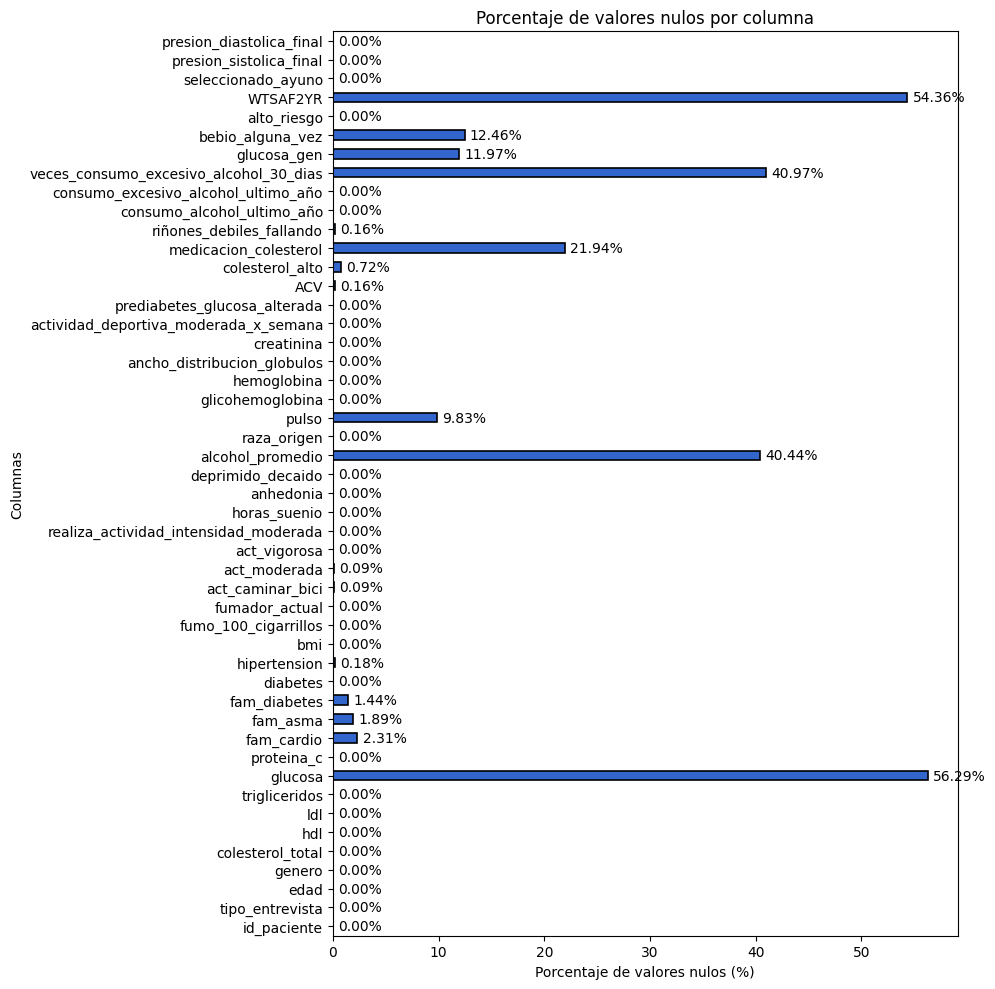

In [234]:
porcentaje_nulos = df_train.isna().mean().round(4) * 100

plt.figure(figsize=(10, 10))
porcentaje_nulos.plot(kind='barh', color="#3366CC", edgecolor='black', linewidth=1.2)

plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Porcentaje de valores nulos (%)')
plt.ylabel('Columnas')

for index, value in enumerate(porcentaje_nulos):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center')

plt.tight_layout()
plt.show()

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id_paciente                             5568 non-null   float64
 1   tipo_entrevista                         5568 non-null   float64
 2   edad                                    5568 non-null   float64
 3   genero                                  5568 non-null   float64
 4   presion_sis_1                           4658 non-null   float64
 5   presion_sis_2                           4885 non-null   float64
 6   presion_sis_3                           4872 non-null   float64
 7   colesterol_total                        5568 non-null   float64
 8   hdl                                     4936 non-null   float64
 9   ldl                                     4788 non-null   float64
 10  trigliceridos                           4924 non-null   floa

| Variable | Imputación |
| --- | --- |
| edad | - |
| genero | - |
| presion_sis_1 | PROM + KNN |
| presion_sis_2 | PROM + KNN |
| presion_sis_3 | PROM + KNN |
| colesterol_total | KNN |
| hdl | KNN |
| ldl | Cálculo + KNN |
| trigliceridos | KNN |
| glucosa | A REVISAR |
| proteina_c | KNN |
| fam_cardio | - |
| fam_asma | - |
| fam_diabetes | - |
| diabetes | - |
| hipertension | - |
| bmi | Mediana por rango de edad |
| fumador_hist | - |
| fumador_actual | ASIGNACIÓN DE VALOR SEGÚN FUNCIONAMIENTO DE LA ENCUESTA |
| act_caminar_bici | - |
| act_moderada | - |
| act_vigorosa | - |
| tiempo_sentado | - |
| horas_suenio | Mediana |
| anhedonia | KNN |
| deprimido_decaido | KNN |
| alcohol_promedio |  |
| raza_origen | - |
| presion_dis_1 | PROM + KNN |
| presion_dis_2 | PROM + KNN |
| presion_dis_3 | PROM + KNN |
| pulso |  |
| glicohemoglobina | KNN(VER SI SE USA) |
| hemoglobina | KNN |
| ancho_distribucion_globulos | KNN |
| creatinina | KNN |
| actividad_deportiva_moderada_x_semana | ASIGNACIÓN DE VALOR SEGÚN FUNCIONAMIENTO DE LA ENCUESTA + KNN |
| prediabetes_glucosa_alterada | KNN |
| ACV | - |
| colesterol_alto | - |
| medicacion_colesterol |  |
| riñones_debiles_fallando | - |
| consumo_alcohol_ultimo_año | ASIGNACIÓN VALOR + KNN |
| consumo_excesivo_alcohol_ultimo_año | ASIGNACIÓN VALOR + KNN |
| veces_consumo_excesivo_alcohol_30_dias |  |
| consumo_actual_tab_sin_humo | - |


In [236]:
# Crear diccionario con los nombres cortos que corresponden solo a tus features
short_names_dict = {
    "SEQN": "id_paciente",
    "RIDSTATR": "tipo_entrevista",
    "RIDAGEYR": "edad",
    "RIAGENDR": "genero",
    "BPXSY1": "presion_sis_1",
    "BPXSY2": "presion_sis_2",
    "BPXSY3": "presion_sis_3",
    "LBXTC": "colesterol_total",
    "LBDHDD": "hdl",
    "LBDLDL": "ldl",
    "LBXTR": "trigliceridos",
    "LBXGLU": "glucosa",
    "LBXHSCRP": "proteina_c",
    "MCQ300A": "fam_cardio",
    "MCQ300B": "fam_asma",
    "MCQ300C": "fam_diabetes",
    "DIQ010": "diabetes",
    "BPQ020": "hipertension",
    "BMXBMI": "bmi",
    "SMQ020": "fumador_hist",
    "SMQ040": "fumador_actual",
    "PAQ605": "act_caminar_bici",
    "PAQ620": "act_moderada",
    "PAQ635": "act_vigorosa",
    "PAQ650": "tiempo_sentado",
    "SLD012": "horas_suenio",
    "DPQ010": "anhedonia",
    "DPQ020": "deprimido_decaido",
    # "DPQ030": "depresion_3",
    # "DPQ040": "depresion_4",
    # "DPQ050": "depresion_5",
    # "DPQ060": "depresion_6",
    # "DPQ070": "depresion_7",
    # "DPQ080": "depresion_8",
    # "DPQ090": "depresion_9",
    "ALQ130": "alcohol_promedio",
    "DR1TSUGR": "azucar_total_dia",
    "SMQ910": "consumo_actual_tab_sin_humo",
    #
    # "RIDRETH1": "Recodificación de información reportada sobre raza y origen hispano",
    "RIDRETH3": "raza_origen",
    "BPXDI1" : "presion_dis_1",
    "BPXDI2" : "presion_dis_2",
    "BPXDI3" : "presion_dis_3",
    "BPXPULS": "pulso", # numerica binaria
    "LBXGH" :	"glicohemoglobina", # numerica
    "LBXHGB":  "hemoglobina",
    "LBXRDW": "ancho_distribucion_globulos",
    "LBXSCR": "creatinina",
    # "PAQ665": "actividad_deportiva moderada, sí/no)",
    "PAQ670": "actividad_deportiva_moderada_x_semana",
    "DIQ160": "prediabetes_glucosa_alterada",
    "MCQ160F": "ACV",
    "BPQ080": "colesterol_alto",
    "BPQ090D": "medicacion_colesterol",
    "KIQ022" : "riñones_debiles_fallando",
    "ALQ121": "consumo_alcohol_ultimo_año",
    "ALQ142": "consumo_excesivo_alcohol_ultimo_año",
    "ALQ170": "veces_consumo_excesivo_alcohol_30_dias",
    "LBDSTRSI": "trigliceridos_2",
    "LBDHDDSI": "hdl_2",
    "LBDGLUSI": "glucosa_2",
    "LBDLDLSI":"ldl_2",
    "LBXSGL": "glucosa_gen"
}

In [237]:
columnas_a_borrar = [
    'id_paciente', 'tipo_entrevista', 'WTSAF2YR',
    'bebio_alguna_vez', 'glucosa_gen', 'medicacion_colesterol',
    'alcohol_promedio', 'pulso','veces_consumo_excesivo_alcohol_30_dias'
]

# Borramos las columnas en df_train y df_test
# errors='ignore' evita que el código falle si alguna columna ya fue borrada antes
df_train = df_train.drop(columns=columnas_a_borrar, errors='ignore')
df_test = df_test.drop(columns=columnas_a_borrar, errors='ignore')

print(f"Columnas eliminadas. Nuevo tamaño de df_train: {df_train.shape}")
print(f"Columnas eliminadas. Nuevo tamaño de df_test: {df_test.shape}")

Columnas eliminadas. Nuevo tamaño de df_train: (4454, 39)
Columnas eliminadas. Nuevo tamaño de df_test: (1114, 39)


In [238]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4454 entries, 4222 to 2158
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   edad                                   4454 non-null   float64
 1   genero                                 4454 non-null   float64
 2   colesterol_total                       4454 non-null   float64
 3   hdl                                    4454 non-null   float64
 4   ldl                                    4454 non-null   float64
 5   trigliceridos                          4454 non-null   float64
 6   glucosa                                1947 non-null   float64
 7   proteina_c                             4454 non-null   float64
 8   fam_cardio                             4351 non-null   float64
 9   fam_asma                               4370 non-null   float64
 10  fam_diabetes                           4390 non-null   float64
 11  diabet

In [239]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1114 entries, 3327 to 4961
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   edad                                   1114 non-null   float64
 1   genero                                 1114 non-null   float64
 2   colesterol_total                       1114 non-null   float64
 3   hdl                                    1114 non-null   float64
 4   ldl                                    1114 non-null   float64
 5   trigliceridos                          1114 non-null   float64
 6   glucosa                                488 non-null    float64
 7   proteina_c                             1114 non-null   float64
 8   fam_cardio                             1090 non-null   float64
 9   fam_asma                               1087 non-null   float64
 10  fam_diabetes                           1097 non-null   float64
 11  diabet

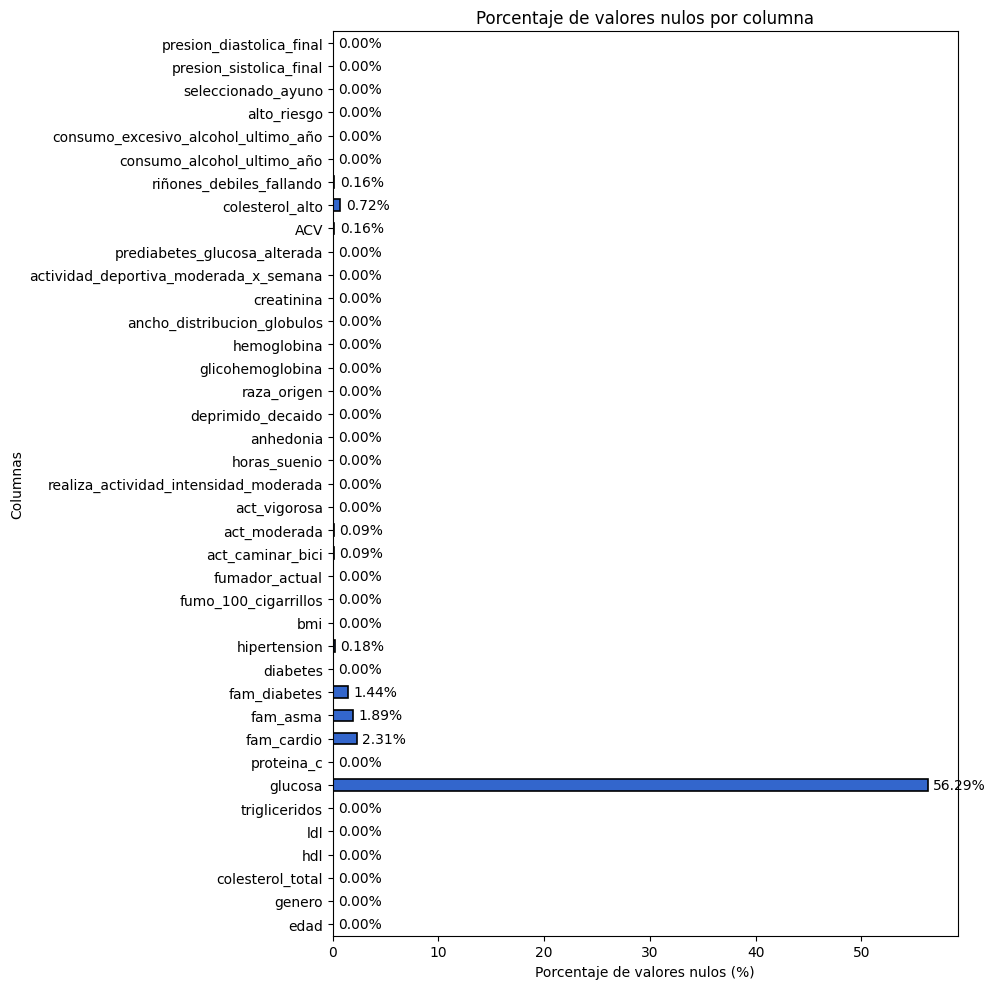

In [240]:
porcentaje_nulos = df_train.isna().mean().round(4) * 100

plt.figure(figsize=(10, 10))
porcentaje_nulos.plot(kind='barh', color="#3366CC", edgecolor='black', linewidth=1.2)

plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Porcentaje de valores nulos (%)')
plt.ylabel('Columnas')

for index, value in enumerate(porcentaje_nulos):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center')

plt.tight_layout()
plt.show()

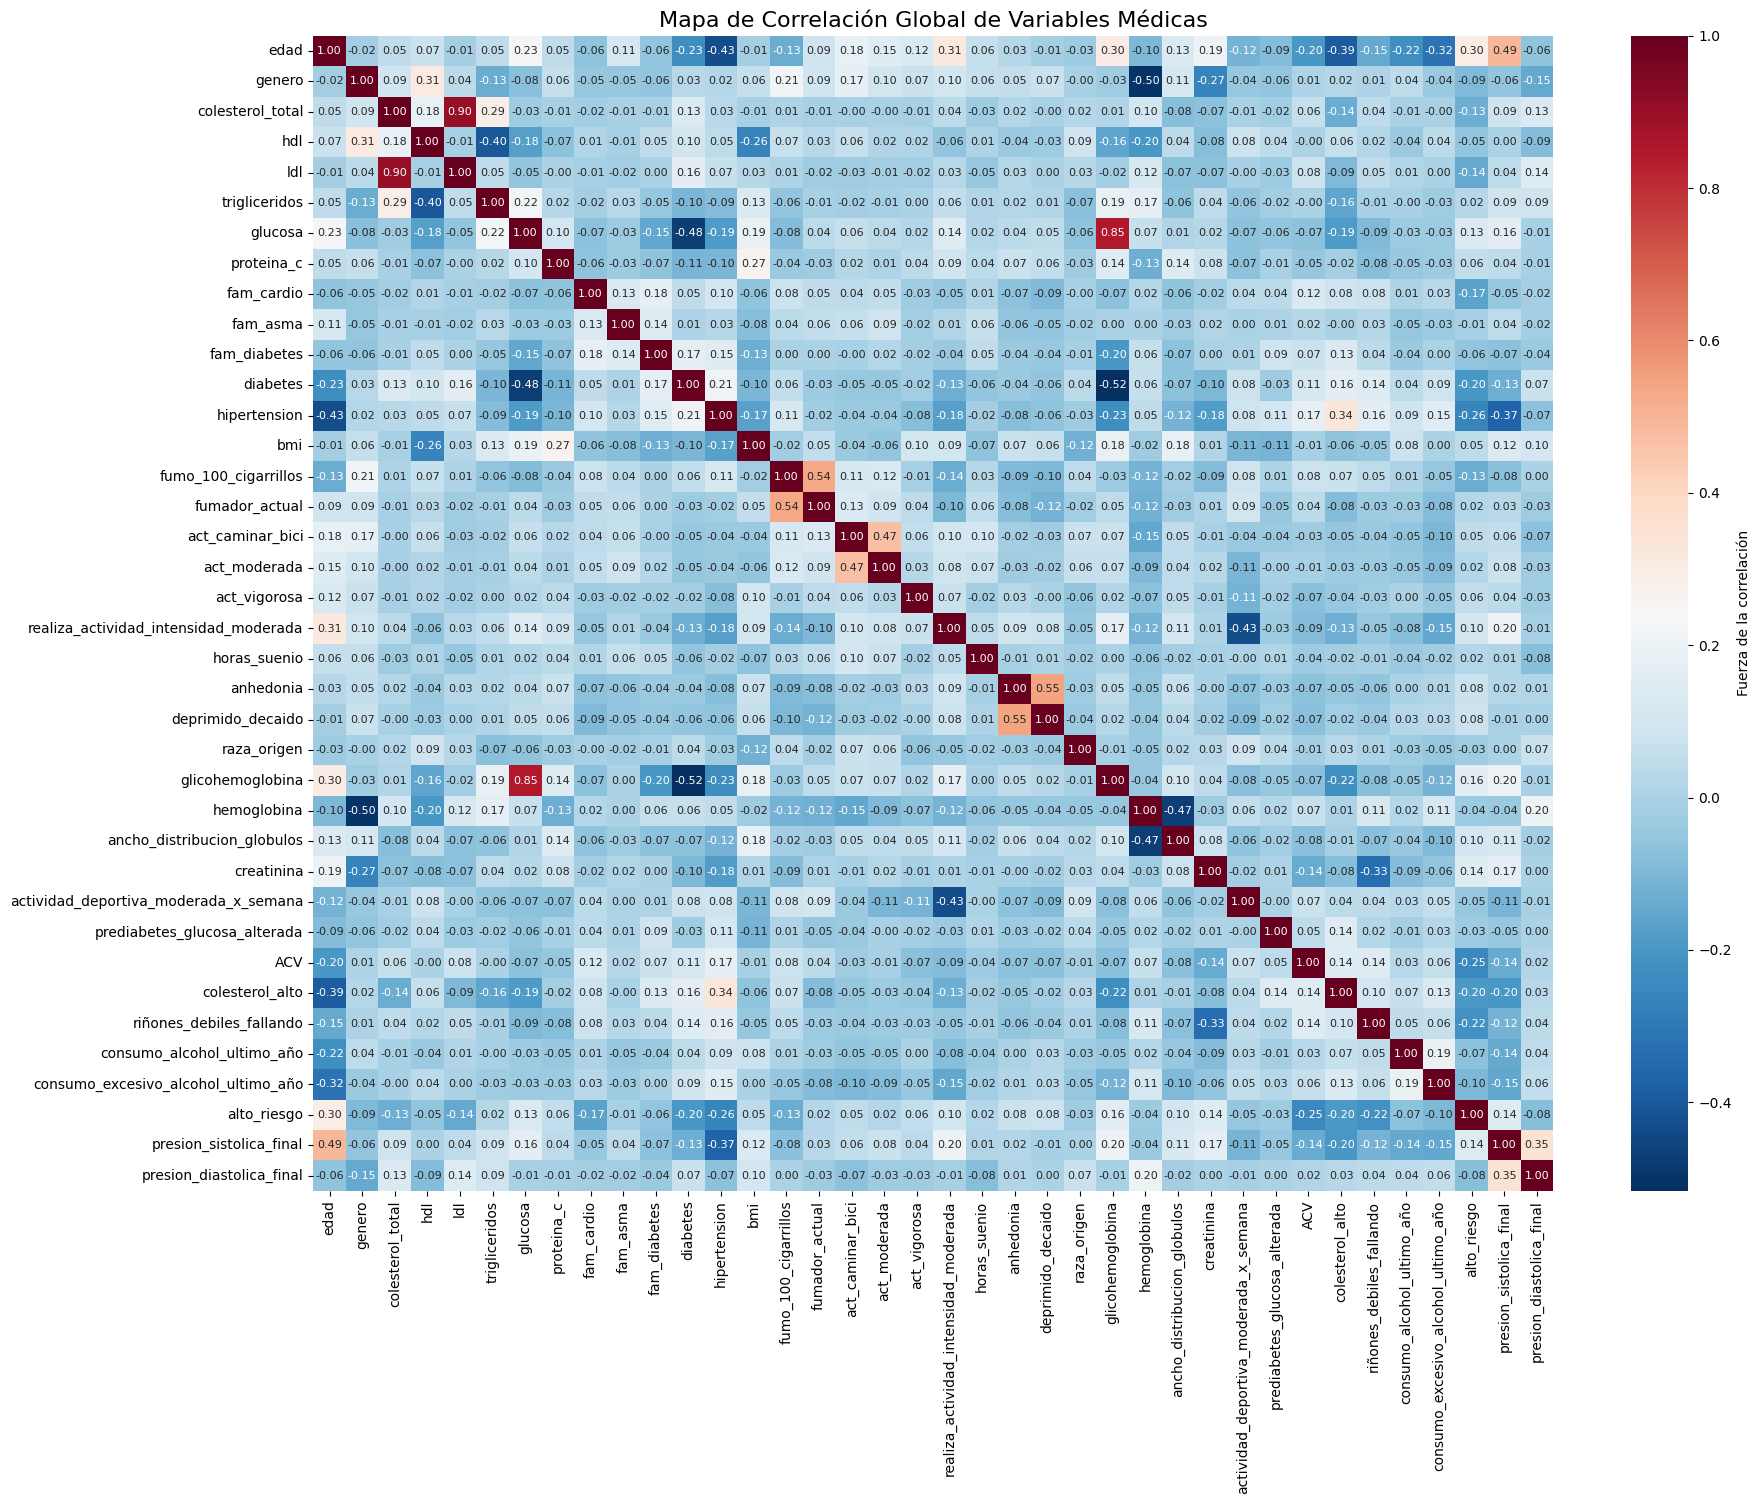

In [241]:
# Seleccionamos todas las variables numéricas y las que ya codificamos a 0/1
# Excluimos solo ID si es que todavía existe, el resto va todo.
cols_completas = df_train.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 15)) # Aumentamos el tamaño para que entre todo

# Calculamos la correlación
matriz_completa = df_train[cols_completas].corr()

# Dibujamos el mapa
sns.heatmap(matriz_completa,
            annot=True,       # Muestra los números
            cmap='RdBu_r',    # Rojo (positivo), Azul (negativo)
            fmt=".2f",        # 2 decimales
            annot_kws={"size": 8}, # Achicamos la letra de los números
            cbar_kws={'label': 'Fuerza de la correlación'})

plt.title('Mapa de Correlación Global de Variables Médicas', fontsize=16)
plt.show()

vemos relacion fuerte entre colesterol total y ldl, y glucosa y glicohemoglobina. Se tomará colesterol total y por el momento glicohemoglobina. Tmabien, vamos a tomr la variable anhedonia y no deprimido_decaido

In [242]:
columnas_a_borrar = [
    'deprimido_decaido', 'ldl', 'glucosa'
]

# Borramos las columnas en df_train y df_test
# errors='ignore' evita que el código falle si alguna columna ya fue borrada antes
df_train = df_train.drop(columns=columnas_a_borrar, errors='ignore')
df_test = df_test.drop(columns=columnas_a_borrar, errors='ignore')

print(f"Columnas eliminadas. Nuevo tamaño de df_train: {df_train.shape}")
print(f"Columnas eliminadas. Nuevo tamaño de df_test: {df_test.shape}")

Columnas eliminadas. Nuevo tamaño de df_train: (4454, 36)
Columnas eliminadas. Nuevo tamaño de df_test: (1114, 36)


## **CODIFICACIÓN**

-------------------------------------------------------------------